### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob

In [3]:
## Use the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/'
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_path+"Train")
data_dir_test = pathlib.Path(root_path+'Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write the train dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Validate the dataset
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset and see the images loaded properly.

(32, 180, 180, 3)
(32,)


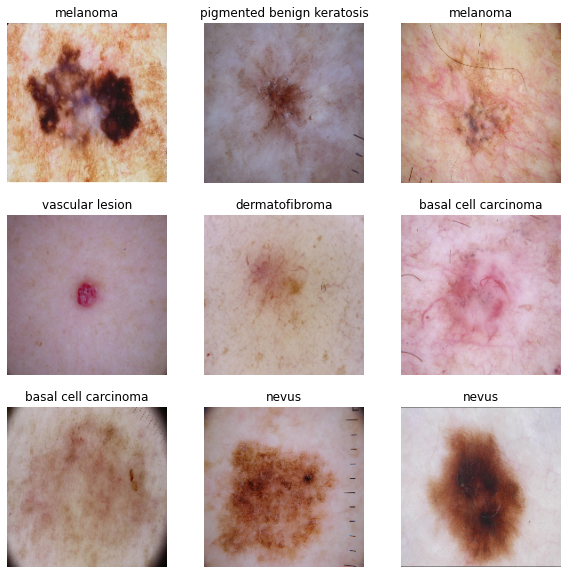

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Using cache for loading the data from disk during first epoch and then keep the images in the in-memory. This helps to improve the performance of the model processing.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # standardize values to be in the [0, 1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

#### Choosing Optimizer and Loss Function

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Sparse Cross Entropy Computes the crossentropy loss between the labels and predictions.

Lets use this crossentropy loss function when there are two or more label classes. We can use the categoricalCrossentropy loss function to provide labels using one-hot representation.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model -1

In [15]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 [==============================] - 194s 312ms/step - loss: 1.9327 - accuracy: 0.2874 - val_loss: 1.7019 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.5703 - accuracy: 0.4436 - val_loss: 1.4790 - val_accuracy: 0.5034
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4384 - accuracy: 0.4978 - val_loss: 1.4334 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3062 - accuracy: 0.5458 - val_loss: 1.3315 - val_accuracy: 0.5526
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2836 - accuracy: 0.5530 - val_loss: 1.3399 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1613 - accuracy: 0.5854 - val_loss: 1.3700 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1158 - accuracy: 0.5971 - val_loss: 1.3214 - val_accuracy: 0.5526
Epoch 8/20

### Visualizing training results

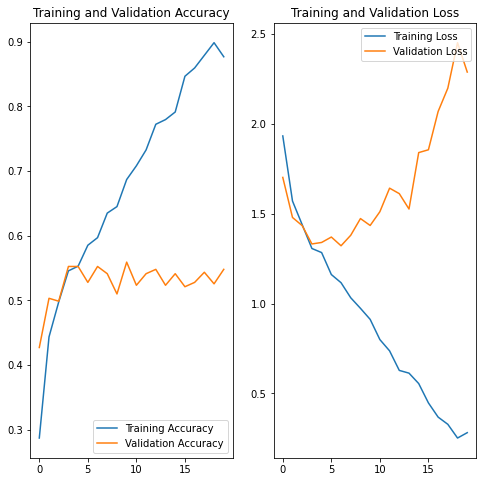

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Observation on the model 1;

   #### Training Accuracy:87% and Validation accuracy:54%

  #### In the above plots, the taining accuracy is increasing linearly over time, however validation accuracy is stay around 50%. There is a significant difference between the trainning accuracy and Validation accuracy.
  #### It is a sign of overfitting.
  #### Let us use Dropout and Augmentation layer to handle this overfitting and create a next module.

### Model 2 - Adding Dropout and augmentation layer with the model 1

### Data Augmentation

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### Verify the Augmentation strategy by visualizing one instance of training image 

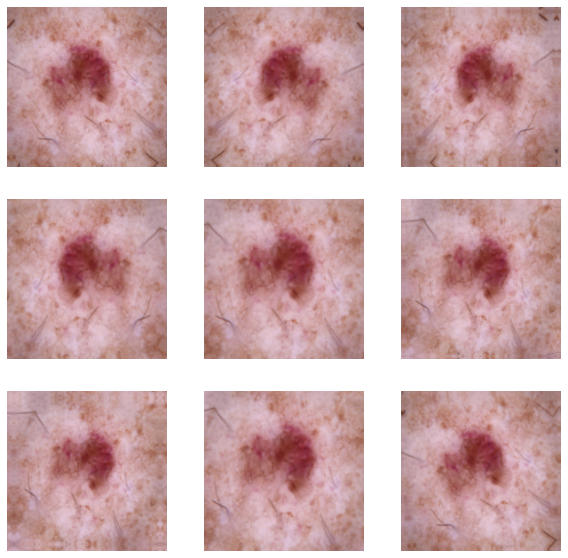

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Dropout is another technique to reduce the overfitting. Dropout the 30% of output units randomly from the applied layer.

In [19]:
# Adding Model, Dropout Layers, Data Augmenting to fix the Overfitting

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'), 
  layers.Dense(num_classes)
])

### Compile model -2

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model -2

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 [==============================] - 3s 43ms/step - loss: 2.0397 - accuracy: 0.2578 - val_loss: 1.8894 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8182 - accuracy: 0.3142 - val_loss: 1.6621 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6427 - accuracy: 0.3990 - val_loss: 1.5204 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5085 - accuracy: 0.4771 - val_loss: 1.5974 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4289 - accuracy: 0.5017 - val_loss: 1.5069 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4044 - accuracy: 0.5156 - val_loss: 1.3929 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3602 - accuracy: 0.5262 - val_loss: 1.5799 - val_accuracy: 0.4362
Epoch 8/20
56

#### Visualize the model -2 training results

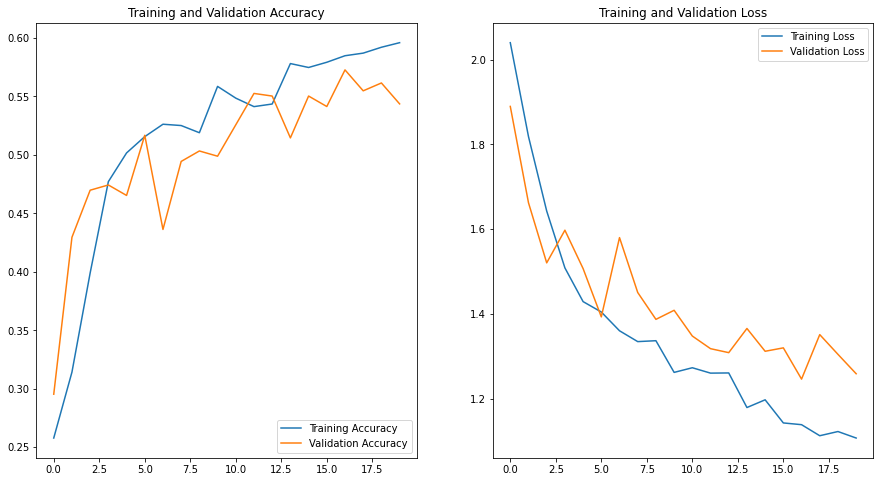

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Outfitting is resolved. However, now the accuracy is 59% for training and 54% for validation. So it is underfitting now.Lets take a look at the dataset distribution and see if there is any possibilities to improve the model 

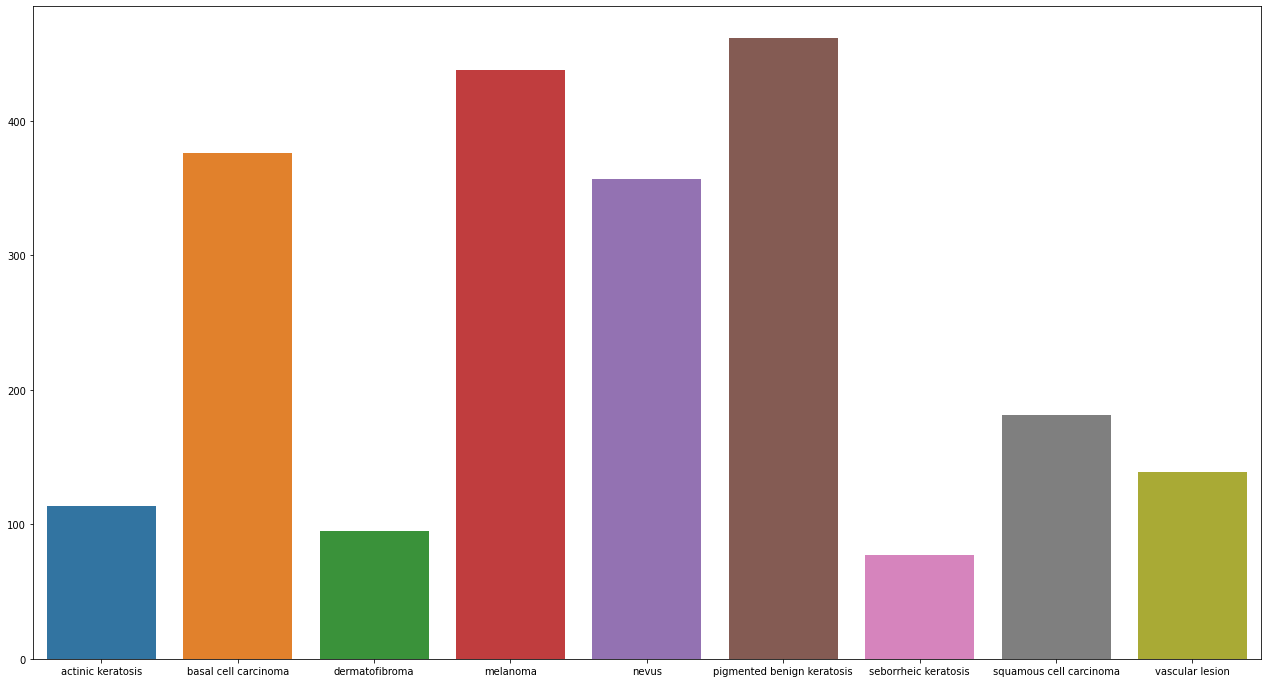

In [23]:
class_dict_orig = {}
for i in class_names:
    class_path = pathlib.Path(root_path+"Train/" + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_orig[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(list(class_dict_orig.keys()), list(class_dict_orig.values()))
plt.show()

In [24]:
pd.DataFrame(list(class_dict_orig.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


### Class Imbalance

The number of image is varying a lot. The lowest data is having 77 images and highest has 462 images.

So, lets try to use the agmentor to create mirror images to the train data set. This will help to improve the number of images in all the classes and the imbalance will get reduce among all the classes.

CNN is cabable of classify the objects even the images are in different orientation. So we cna add small changes in the agmentor like flips or rotation of the images and create a new set of mirror images.

And then use the updated data set to train the model along with the dropout, augmentation layers.

### Rectify the Class Imbalance

#### Augmentor - Data Augmentation Package

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
# Install a pip package in the current Jupyter kernel
import shutil, sys 
!{sys.executable} -m pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import Augmentor
data_dir_train = root_path + "Train_class_balanced/"

#if path already exists, remove it before copying with copytree()
if os.path.exists(data_dir_train):
  shutil.rmtree(data_dir_train)
  shutil.copytree(root_path+"Train/", data_dir_train)
else:
  shutil.copytree(root_path+"Train/", data_dir_train)

for i in class_names:
    print(root_path+"Train/" + i+"\n")
    p = Augmentor.Pipeline(data_dir_train + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE8ABC80750>: 100%|██████████| 500/500 [00:18<00:00, 27.41 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE8AA0C2910>: 100%|██████████| 500/500 [00:19<00:00, 25.90 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE8AAF29310>: 100%|██████████| 500/500 [00:18<00:00, 27.72 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE8ABDB3FD0>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FE8A27855D0>: 100%|██████████| 500/500 [01:16<00:00,  6.58 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE8AACFD350>: 100%|██████████| 500/500 [00:19<00:00, 25.36 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE8ADBA1D50>: 100%|██████████| 500/500 [00:40<00:00, 12.40 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE8ABE129D0>: 100%|██████████| 500/500 [00:18<00:00, 26.91 Samples/s]


gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Assignment_Data/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train_class_balanced/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE8ABC927D0>: 100%|██████████| 500/500 [00:17<00:00, 28.07 Samples/s]


### Lets see the distribution of augmented data after adding new images to the original training data.

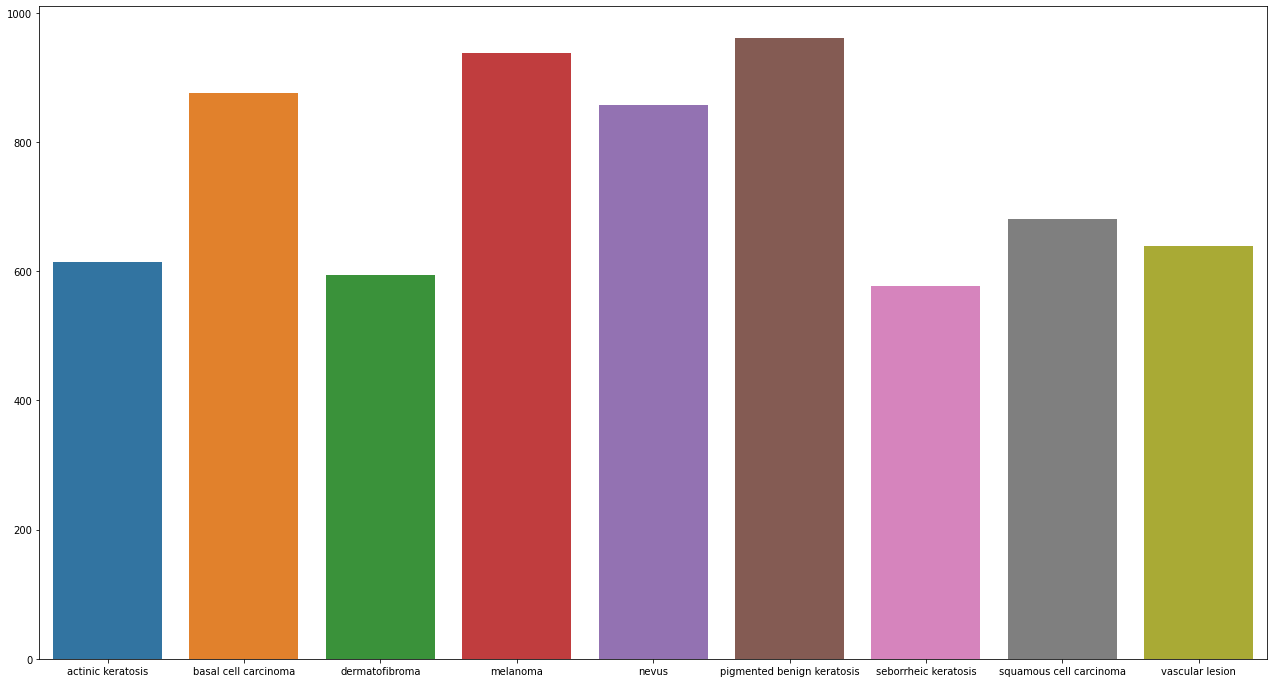

In [42]:
class_dict_new = {}
for i in class_names:
    class_path = pathlib.Path(data_dir_train + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_Output_path = pathlib.Path(data_dir_train + i+"/output")
    class_Output_count = len(list(class_Output_path.glob('*.jpg')))
    class_dict_new[i] = class_count + class_Output_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(list(class_dict_new.keys()), list(class_dict_new.values()))
plt.show()

In [43]:
pd.DataFrame(list(class_dict_new.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,577
2,dermatofibroma,595
0,actinic keratosis,614
8,vascular lesion,639
7,squamous cell carcinoma,681
4,nevus,857
1,basal cell carcinoma,876
3,melanoma,938
5,pigmented benign keratosis,962


#### Class Imbalance is Rectified - All Classes have a minimum of 500 Images

### Model 3 : Model -1 + Dropout Layer + Data Augmentation (to counter overfitting) + Class Imbalance (to counter class imbalance) <br>

- Creating New Augmented Train Loader
- Creating New Augmented Validation Loader
- Train for 50 Epochs as data increased

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [35]:
# Vanilla Model + Dropout Layers + Data Augmentation + Class balanced Dataset

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'), 
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=True
)

Epoch 1/50
169/169 [==============================] - 34s 192ms/step - loss: 1.8969 - accuracy: 0.2685 - val_loss: 1.5907 - val_accuracy: 0.3979
Epoch 2/50
169/169 [==============================] - 33s 189ms/step - loss: 1.5123 - accuracy: 0.4214 - val_loss: 1.4165 - val_accuracy: 0.4662
Epoch 3/50
169/169 [==============================] - 33s 190ms/step - loss: 1.4249 - accuracy: 0.4555 - val_loss: 1.3555 - val_accuracy: 0.4944
Epoch 4/50
169/169 [==============================] - 33s 188ms/step - loss: 1.3513 - accuracy: 0.4807 - val_loss: 1.3483 - val_accuracy: 0.4878
Epoch 5/50
169/169 [==============================] - 34s 198ms/step - loss: 1.2829 - accuracy: 0.5024 - val_loss: 1.3127 - val_accuracy: 0.4959
Epoch 6/50
169/169 [==============================] - 33s 188ms/step - loss: 1.2450 - accuracy: 0.5260 - val_loss: 1.2983 - val_accuracy: 0.5130
Epoch 7/50
169/169 [==============================] - 33s 190ms/step - loss: 1.2050 - accuracy: 0.5393 - val_loss: 1.1420 - val_ac

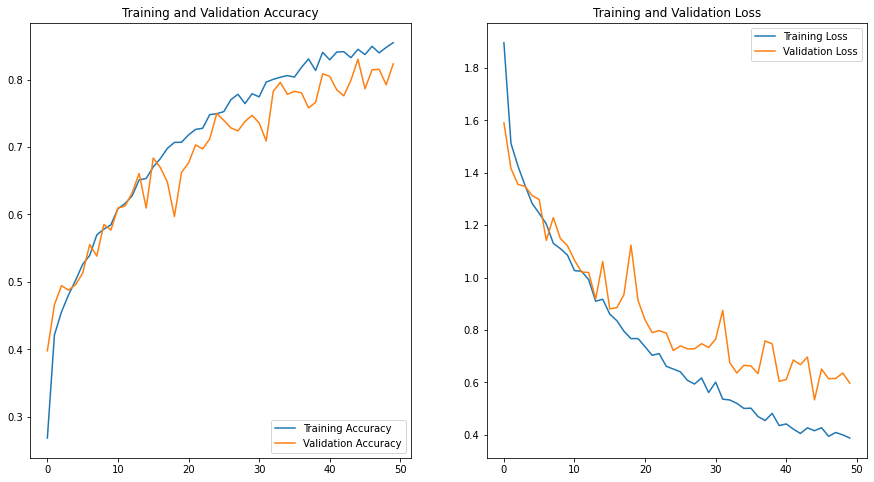

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Underfitting is Resolved

### Model 3 : Accuracy is 85% on Training and 82% on Validation after running 50 epochs which is decent enough and more generalizable Model

## Summary

* Model -1: Basic Model
  * Model Training is not having good accuracy - Training accuracy 81% and Validation Accuracy 53%  
  * Model was **Overfitting**

* Model -2: Model 1 + Dropout Layers + Data Augmentation
  * Dropout Layers Added
  * Data Augmentation layer was added
  * Accuracy of the model is reduced compare to model -1 - Training Accuracy 56% and Validation Accuracy 51%
  * Model was **Underfitting** due to the class imbalance

* Model -3: Model 2 + Class balanced Dataset
  * To fix the class imbalance issue, Dataset Added using Augmentor (500 images added per class)
  * Same Model 2 was used.
  * The accuracy of the model is improved. So, handling the class imbalance give better result and this model is reliable model.